# 📊 Analyse des interventions non facturées
Ce notebook présente l'analyse des interventions pédagogiques à facturer, en se basant sur les données extraites depuis la base Notion via l'API.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import os
import requests

load_dotenv()
NOTION_TOKEN = os.getenv("NOTION_TOKEN")
DB_INTERVENTIONS_ID = os.getenv("DB_INTERVENTIONS_ID")

HEADERS = {
    "Authorization": f"Bearer {NOTION_TOKEN}",
    "Notion-Version": "2022-06-28",
    "Content-Type": "application/json"
}

/Users/imanebenamar/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [10]:
def get_unbilled_interventions(date_start, date_end):
    query = {
        "filter": {
            "and": [
                {"property": "Facturé", "checkbox": {"equals": False}},
                {"property": "Date de début", "date": {"on_or_after": date_start}},
                {"property": "Date de début", "date": {"before": date_end}}
            ]
        }
    }
    url = f"https://api.notion.com/v1/databases/{DB_INTERVENTIONS_ID}/query"
    response = requests.post(url, headers=HEADERS, json=query)
    response.raise_for_status()
    return response.json()["results"]

In [12]:
def convert_to_dataframe(results):
    data = []
    for item in results:
        props = item["properties"]
        data.append({
            "Cours": props["Cours"]["title"][0]["text"]["content"] if props["Cours"]["title"] else None,
            "École": props["Ecole"]["select"]["name"] if props["Ecole"]["select"] else None,
            "Classe": props["Classe"]["select"]["name"] if props["Classe"]["select"] else None,
            "Ville": props["Ville"]["select"]["name"] if props["Ville"]["select"] else None,
            "Heures": props["Nombre heures"]["number"],
            "Tarif horaire": props["Tarif horaire"]["number"],
            "Total": round(props["Nombre heures"]["number"] * props["Tarif horaire"]["number"], 2),
            "Date": props["Date de début"]["date"]["start"] if props["Date de début"]["date"] else None
        })
    return pd.DataFrame(data)

In [14]:
def analyse_par_ville(df):
    return df.groupby("Ville")[["Heures", "Total"]].sum()

In [15]:
def analyse_par_ecole_et_classe(df):
    return df.groupby(["École", "Classe"])["Heures"].sum()

In [17]:
def analyse_par_mois(df):
    df["Mois"] = pd.to_datetime(df["Date"]).dt.to_period("M")
    return df.groupby("Mois")[["Heures", "Total"]].sum()

In [18]:
def analyse_complete(date_start, date_end):
    results = get_unbilled_interventions(date_start, date_end)
    df = convert_to_dataframe(results)

    print("🔍 Aperçu des données :")
    display(df)

    print("\n🏙️ Analyse par ville :")
    display(analyse_par_ville(df))

    print("\n🏫 Analyse par école et classe :")
    display(analyse_par_ecole_et_classe(df))

    print("\n📆 Analyse par mois :")
    display(analyse_par_mois(df))

    # Visualisation
    df.groupby("École")["Heures"].sum().plot(kind="bar", title="Heures par école")
    plt.ylabel("Nombre d’heures")
    plt.show()

    return df

🔍 Aperçu des données :


,Cours,École,Classe,Ville,Heures,Tarif horaire,Total,Date
0,Régression linéaire session 1,ENSIIE,M1 Maths,Evry,3.5,10,35.0,2025-04-23
1,Mathématiques pour l’informatique session 1,ENSIIE,L3,Evry,3.5,5,17.5,2025-04-23
2,Innovation en IA & Transformation des organisa...,EPITECH Digital,M1,Le Kremlin-Bicêtre,7.0,10,70.0,2025-03-05
3,Mathématiques pour l’informatique session 2,NEXA Digital School,BTS SIO,Paris,3.5,15,52.5,2025-05-23
4,Innovation en IA & Transformation des organisa...,EPITECH Digital,M1,Le Kremlin-Bicêtre,7.0,10,70.0,2025-03-05
5,Mathématiques pour l’informatique session 1,NEXA Digital School,BTS SIO,Paris,3.5,15,52.5,2025-04-23
6,A la découverte du framework TensorFlow de Go...,ESIEE,M1,Noisy-le-Grand,35.0,10,350.0,2025-06-30
7,Mathématiques pour l’informatique session 2,ENSIIE,L3,Evry,3.5,5,17.5,2025-05-16
8,Régression linéaire session 2,ENSIIE,M1 Maths,Evry,3.5,10,35.0,2025-05-16
9,Innovation en IA & Transformation des organis...,EPITECH Digital,M1,Le Kremlin-Bicêtre,7.0,10,70.0,2025-03-19



🏙️ Analyse par ville :


,Heures,Total
Ville,,
Evry,14.0,105.0
Le Kremlin-Bicêtre,21.0,210.0
Noisy-le-Grand,35.0,350.0
Paris,7.0,105.0



🏫 Analyse par école et classe :


École                Classe  
ENSIIE               L3           7.0
                     M1 Maths     7.0
EPITECH Digital      M1          21.0
ESIEE                M1          35.0
NEXA Digital School  BTS SIO      7.0
Name: Heures, dtype: float64


📆 Analyse par mois :


,Heures,Total
Mois,,
2025-03,21.0,210.0
2025-04,10.5,105.0
2025-05,10.5,105.0
2025-06,35.0,350.0


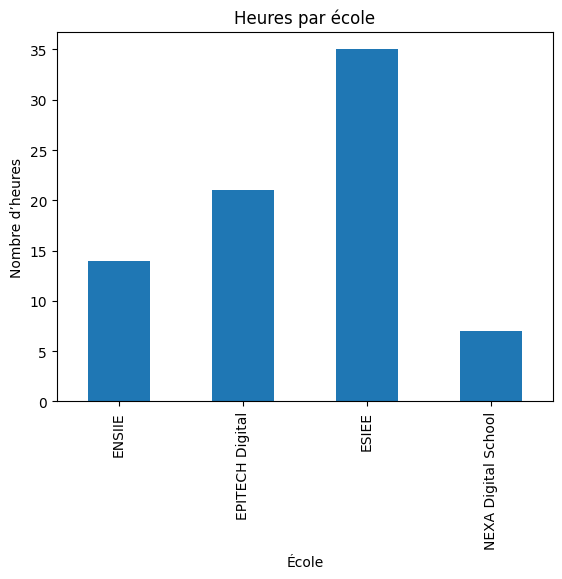

,Cours,École,Classe,Ville,Heures,Tarif horaire,Total,Date,Mois
0,Régression linéaire session 1,ENSIIE,M1 Maths,Evry,3.5,10,35.0,2025-04-23,2025-04
1,Mathématiques pour l’informatique session 1,ENSIIE,L3,Evry,3.5,5,17.5,2025-04-23,2025-04
2,Innovation en IA & Transformation des organisa...,EPITECH Digital,M1,Le Kremlin-Bicêtre,7.0,10,70.0,2025-03-05,2025-03
3,Mathématiques pour l’informatique session 2,NEXA Digital School,BTS SIO,Paris,3.5,15,52.5,2025-05-23,2025-05
4,Innovation en IA & Transformation des organisa...,EPITECH Digital,M1,Le Kremlin-Bicêtre,7.0,10,70.0,2025-03-05,2025-03
5,Mathématiques pour l’informatique session 1,NEXA Digital School,BTS SIO,Paris,3.5,15,52.5,2025-04-23,2025-04
6,A la découverte du framework TensorFlow de Go...,ESIEE,M1,Noisy-le-Grand,35.0,10,350.0,2025-06-30,2025-06
7,Mathématiques pour l’informatique session 2,ENSIIE,L3,Evry,3.5,5,17.5,2025-05-16,2025-05
8,Régression linéaire session 2,ENSIIE,M1 Maths,Evry,3.5,10,35.0,2025-05-16,2025-05
9,Innovation en IA & Transformation des organis...,EPITECH Digital,M1,Le Kremlin-Bicêtre,7.0,10,70.0,2025-03-19,2025-03


In [19]:
# 📅 Lancer une analyse sur juin 2025
analyse_complete("2025-03-01", "2025-07-01")